In [1]:
import pandas as pd
from DCC import *
from Utils import *
from Plots import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from collections import defaultdict

init_plotting()

df = pd.read_csv("results/dcc_results.csv")
# df.drop(columns=["dataset"], inplace=True, errors="ignore")
df

type  original_scores  original_scores_std    scores  \
0    classification         0.892254             0.050522  0.900000   
1    classification         0.892254             0.050522  0.872085   
2    classification         0.892254             0.050522  0.897085   
3    classification         0.892254             0.050522  0.881350   
4    classification         0.892254             0.050522  0.866208   
..              ...              ...                  ...       ...   
380      regression         0.822613             0.060846  0.782737   
381      regression         0.822613             0.060846  0.704339   
382      regression         0.822613             0.060846  0.583572   
383      regression         0.822613             0.060846  0.658487   
384      regression         0.822613             0.060846  0.585656   

     scores_std  dcc_pearson  dcc_spearman  dcc_kendall    dcc_mi    dcc_js  \
0      0.041102     0.978022      1.000000     1.000000  1.000000  1.000000   
1      0.043611     0.560440      0.692308     0.802198  0.857143  0.846154   
2      0.042266     0.582418      0.626374     0.747253  0.791209  0.736264   
3      0.053609     0.472527      0.670330     0.769231  0.890110  0.692308   
4      0.064875     0.571429      0.692308     0.824176  0.857143  0.747253   
..          ...          ...           ...          ...       ...       ...   
380    0.052271     0.933333      0.876190     0.971429  0.780952  1.000000   
381    0.077230     0.295238      0.376190     0.457143  0.547619  0.342857   
382    0.091257     0.261905      0.390476     0.423810  0.566667  0.238095   
383    0.085550     0.295238      0.309524     0.404762  0.490476  0.209524   
384    0.127603     0.242857      0.333333     0.390476  0.590476  0.142857   

     ...  corr_cnt_good_pearson  corr_cnt_good_spearman  \
0    ...               0.000000                     0.0   
1    ...               0.000000                     0.0   
2    ...               0.000000                     0.0   
3    ...               0.000000                     0.0   
4    ...               0.000000                     0.0   
..   ...                    ...                     ...   
380  ...               0.263158                     0.0   
381  ...               0.052632                     0.0   
382  ...               0.000000                     0.0   
383  ...               0.105263                     0.0   
384  ...               0.000000                     0.0   

     corr_cnt_good_kendall corr_cnt_good_mi corr_cnt_good_js  \
0                      0.0              0.0         0.416667   
1                      0.0              0.0         0.500000   
2                      0.0              0.0         0.416667   
3                      0.0              0.0         0.416667   
4                      0.0              0.0         0.416667   
..                     ...              ...              ...   
380                    0.0              0.0         0.105263   
381                    0.0              0.0         0.000000   
382                    0.0              0.0         0.000000   
383                    0.0              0.0         0.000000   
384                    0.0              0.0         0.000000   

     corr_cnt_good_wd  corr_cnt_good_xi  corr_cnt_good_dcor  scores_ratio  \
0            0.583333          0.000000            0.000000      1.008682   
1            0.666667          0.000000            0.000000      0.977396   
2            0.750000          0.083333            0.000000      1.005415   
3            0.666667          0.000000            0.000000      0.987779   
4            0.666667          0.000000            0.000000      0.970809   
..                ...               ...                 ...           ...   
380          0.000000          0.000000            0.210526      0.951525   
381          0.000000          0.000000            0.052632      0.856221   
382          0.000000          0.000000   

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
)
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from IPython.display import display


def cross_validate_model(model, X, y, cv=3):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)
    return np.mean(scores), np.std(scores)


def exp(df_all):
    print(df_all.shape)
    categorical_cols = df_all.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df_all[col] = le.fit_transform(df_all[col].astype(str))
    fig, ax = plt.subplots(figsize=(32, 32))
    sns.heatmap(
        df_all.corr(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        square=True,
    )
    plt.show()
    all_targets = [
        "original_scores",
        "original_scores_std",
        "scores",
        "scores_std",
        "scores_ratio",
        "scores_std_ratio",
    ]
    X = df_all.drop(columns=all_targets)
    print("Used features:", X.columns.tolist())
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=100, random_state=42
        ),
        "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
        "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
        "Support Vector Regression": SVR(kernel="linear"),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
    }
    results = defaultdict(dict)
    for target in all_targets:
        Y = df_all[target]
        print(f"Evaluating models for target: {target}")
        for model_name, model in models.items():
            mean_score, std_score = cross_validate_model(model, X, Y, cv=3)
            results[target][model_name] = f"{mean_score:.4f} ± {std_score:.4f}"
    results_df = pd.DataFrame(results).T
    display(results_df)

In [3]:
all_cols = [
    "type",
    "original_scores",
    "original_scores_std",
    "scores",
    "scores_std",
    "dcc_pearson",
    "dcc_spearman",
    "dcc_kendall",
    "dcc_mi",
    "dcc_js",
    "dcc_wd",
    "dcc_xi",
    "dcc_dcor",
    "perturbation_type",
    "dataset",
    "ptb_ratio",
    "corr_max_pearson",
    "corr_max_spearman",
    "corr_max_kendall",
    "corr_max_mi",
    "corr_max_js",
    "corr_max_wd",
    "corr_max_xi",
    "corr_max_dcor",
    "corr_cnt_good_pearson",
    "corr_cnt_good_spearman",
    "corr_cnt_good_kendall",
    "corr_cnt_good_mi",
    "corr_cnt_good_js",
    "corr_cnt_good_wd",
    "corr_cnt_good_xi",
    "corr_cnt_good_dcor",
    "scores_ratio",
    "scores_std_ratio",
]

In [4]:
df_all = df.copy()
df_all.drop(columns=["dataset"], inplace=True, errors="ignore")
categorical_cols = df_all.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))
# df_all = df.select_dtypes(include=[np.number])
fig, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(
    df_all.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar=False,
)

<Axes: >

In [5]:
X_cols = df.columns.drop(
    [
        "original_scores",
        "original_scores_std",
        "scores",
        "scores_std",
        "scores_ratio",
        "scores_std_ratio",
    ]
).tolist()
X_cols

['type',
 'dcc_pearson',
 'dcc_spearman',
 'dcc_kendall',
 'dcc_mi',
 'dcc_js',
 'dcc_wd',
 'dcc_xi',
 'dcc_dcor',
 'perturbation_type',
 'dataset',
 'ptb_ratio',
 'corr_max_pearson',
 'corr_max_spearman',
 'corr_max_kendall',
 'corr_max_mi',
 'corr_max_js',
 'corr_max_wd',
 'corr_max_xi',
 'corr_max_dcor',
 'corr_cnt_good_pearson',
 'corr_cnt_good_spearman',
 'corr_cnt_good_kendall',
 'corr_cnt_good_mi',
 'corr_cnt_good_js',
 'corr_cnt_good_wd',
 'corr_cnt_good_xi',
 'corr_cnt_good_dcor']

In [6]:
X_cols = [
    # "type",
    "dcc_pearson",
    "dcc_spearman",
    "dcc_kendall",
    "dcc_mi",
    "dcc_js",
    "dcc_wd",
    "dcc_xi",
    "dcc_dcor",
    # "perturbation_type",
    # "ptb_ratio",
    "corr_max_pearson",
    "corr_max_spearman",
    "corr_max_kendall",
    "corr_max_mi",
    "corr_max_js",
    "corr_max_wd",
    "corr_max_xi",
    "corr_max_dcor",
]

In [7]:
select_cols = (
    ["scores", "scores_ratio"] + X_cols 
)
cur_df = df[select_cols].copy()
categorical_cols = cur_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    cur_df[col] = le.fit_transform(cur_df[col].astype(str))

from scipy.stats import boxcox
from scipy.special import inv_boxcox

cur_df["scores_boxcox"], fitted_lambda = boxcox(cur_df["scores"])
cur_df["scores_ratio_boxcox"], fitted_lambda_ratio = boxcox(cur_df["scores_ratio"])

cur_df

scores  scores_ratio  dcc_pearson  dcc_spearman  dcc_kendall    dcc_mi  \
0    0.900000      1.008682     0.978022      1.000000     1.000000  1.000000   
1    0.872085      0.977396     0.560440      0.692308     0.802198  0.857143   
2    0.897085      1.005415     0.582418      0.626374     0.747253  0.791209   
3    0.881350      0.987779     0.472527      0.670330     0.769231  0.890110   
4    0.866208      0.970809     0.571429      0.692308     0.824176  0.857143   
..        ...           ...          ...           ...          ...       ...   
380  0.782737      0.951525     0.933333      0.876190     0.971429  0.780952   
381  0.704339      0.856221     0.295238      0.376190     0.457143  0.547619   
382  0.583572      0.709413     0.261905      0.390476     0.423810  0.566667   
383  0.658487      0.800482     0.295238      0.309524     0.404762  0.490476   
384  0.585656      0.711946     0.242857      0.333333     0.390476  0.590476   

       dcc_js    dcc_wd    dcc_xi  dcc_dcor  corr_max_pearson  \
0    1.000000  1.000000  0.307692  1.000000          0.451314   
1    0.846154  0.846154  0.362637  0.868132          0.396166   
2    0.736264  0.824176  0.406593  0.780220          0.430984   
3    0.692308  0.769231  0.362637  0.802198          0.448574   
4    0.747253  0.802198  0.384615  0.813187          0.386699   
..        ...       ...       ...       ...               ...   
380  1.000000  0.995238  0.280952  0.961905          0.655622   
381  0.342857  0.457143  0.285714  0.357143          0.552707   
382  0.238095  0.490476  0.190476  0.266667          0.480480   
383  0.209524  0.333333  0.166667  0.309524          0.516253   
384  0.142857  0.471429  0.152381  0.319048          0.497334   

     corr_max_spearman  corr_max_kendall  corr_max_mi  corr_max_js  \
0             0.441393          0.361966     0.166466     0.574333   
1             0.396387          0.324945     0.112235     0.573394   
2             0.416371          0.341303     0.149231     0.573213   
3             0.437737          0.358860     0.142557     0.557507   
4             0.384260          0.314959     0.129708     0.569416   
..                 ...               ...          ...          ...   
380           0.481563          0.350531     0.250519     0.532480   
381           0.448477          0.318529     0.179164     0.454638   
382           0.421888          0.306864     0.178672     0.436648   
383           0.435470          0.316086     0.185899     0.437891   
384           0.467067          0.344964     0.182122     0.422993   

     corr_max_wd  corr_max_xi  corr_max_dcor  scores_boxcox  \
0       0.909919     0.362232       0.425279      -0.092528   
1       0.874012     0.491441       0.384753      -0.115751   
2       0.873516     0.508087       0.404915      -0.095005   
3       0.872368     0.482904       0.425134      -0.108167   
4       0.863324     0.449791       0.370654      -0.120499   
..           ...          ...            ...            ...   
380     0.484035     0.300795       0.586815      -0.182754   
381     0.380530     0.332165       0.503830      -0.232723   
382     0.426833     0.327960       0.505112      -0.294623   
383     0.400611     0.316619       0.482002      -0.258310   
384     0.439096     0.334277       0.475335      -0.293702   

     scores_ratio_boxcox  
0               0.008809  
1              -0.021761  
2               0.005465  
3              -0.011973  
4              -0.027793  
..                   ...  
380            -0.044678  
381            -0.112803  
382            -0.178068  
383            -0.142464  
384            -0.177263  

[385 rows x 20 columns]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

def plot_rfecv(X, y, estimator, cv=5, scoring="r2"):
    """
    使用 RFECV (递归特征消除 + 交叉验证) 并绘制性能变化图。

    Parameters:
    - X: 特征数据 (ndarray or DataFrame)
    - y: 标签数据
    - estimator: 基学习器 (如 RandomForestRegressor, SVR 等)
    - cv: 交叉验证折数 (默认 5)
    - scoring: 模型评估指标 (默认 "r2")
    """
    # 定义交叉验证器
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=42)

    # RFECV 自动递归消除 + CV
    selector = RFECV(estimator, step=1, cv=cv_splitter,
                     scoring=scoring, n_jobs=-1)
    selector.fit(X, y)
    return selector, selector.cv_results_


Used cols ['scores', 'dcc_pearson', 'dcc_spearman', 'dcc_kendall', 'dcc_mi', 'dcc_js', 'dcc_wd', 'dcc_xi', 'dcc_dcor', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_xi', 'corr_max_dcor']
Selected features: ['dcc_js', 'dcc_xi', 'dcc_dcor', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_xi', 'corr_max_dcor']
Number of selected features: 11
Used cols ['scores_ratio', 'dcc_pearson', 'dcc_spearman', 'dcc_kendall', 'dcc_mi', 'dcc_js', 'dcc_wd', 'dcc_xi', 'dcc_dcor', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_xi', 'corr_max_dcor']
Selected features: ['dcc_pearson', 'dcc_dcor', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_xi', 'corr_max_dcor']
Number of selected features: 10


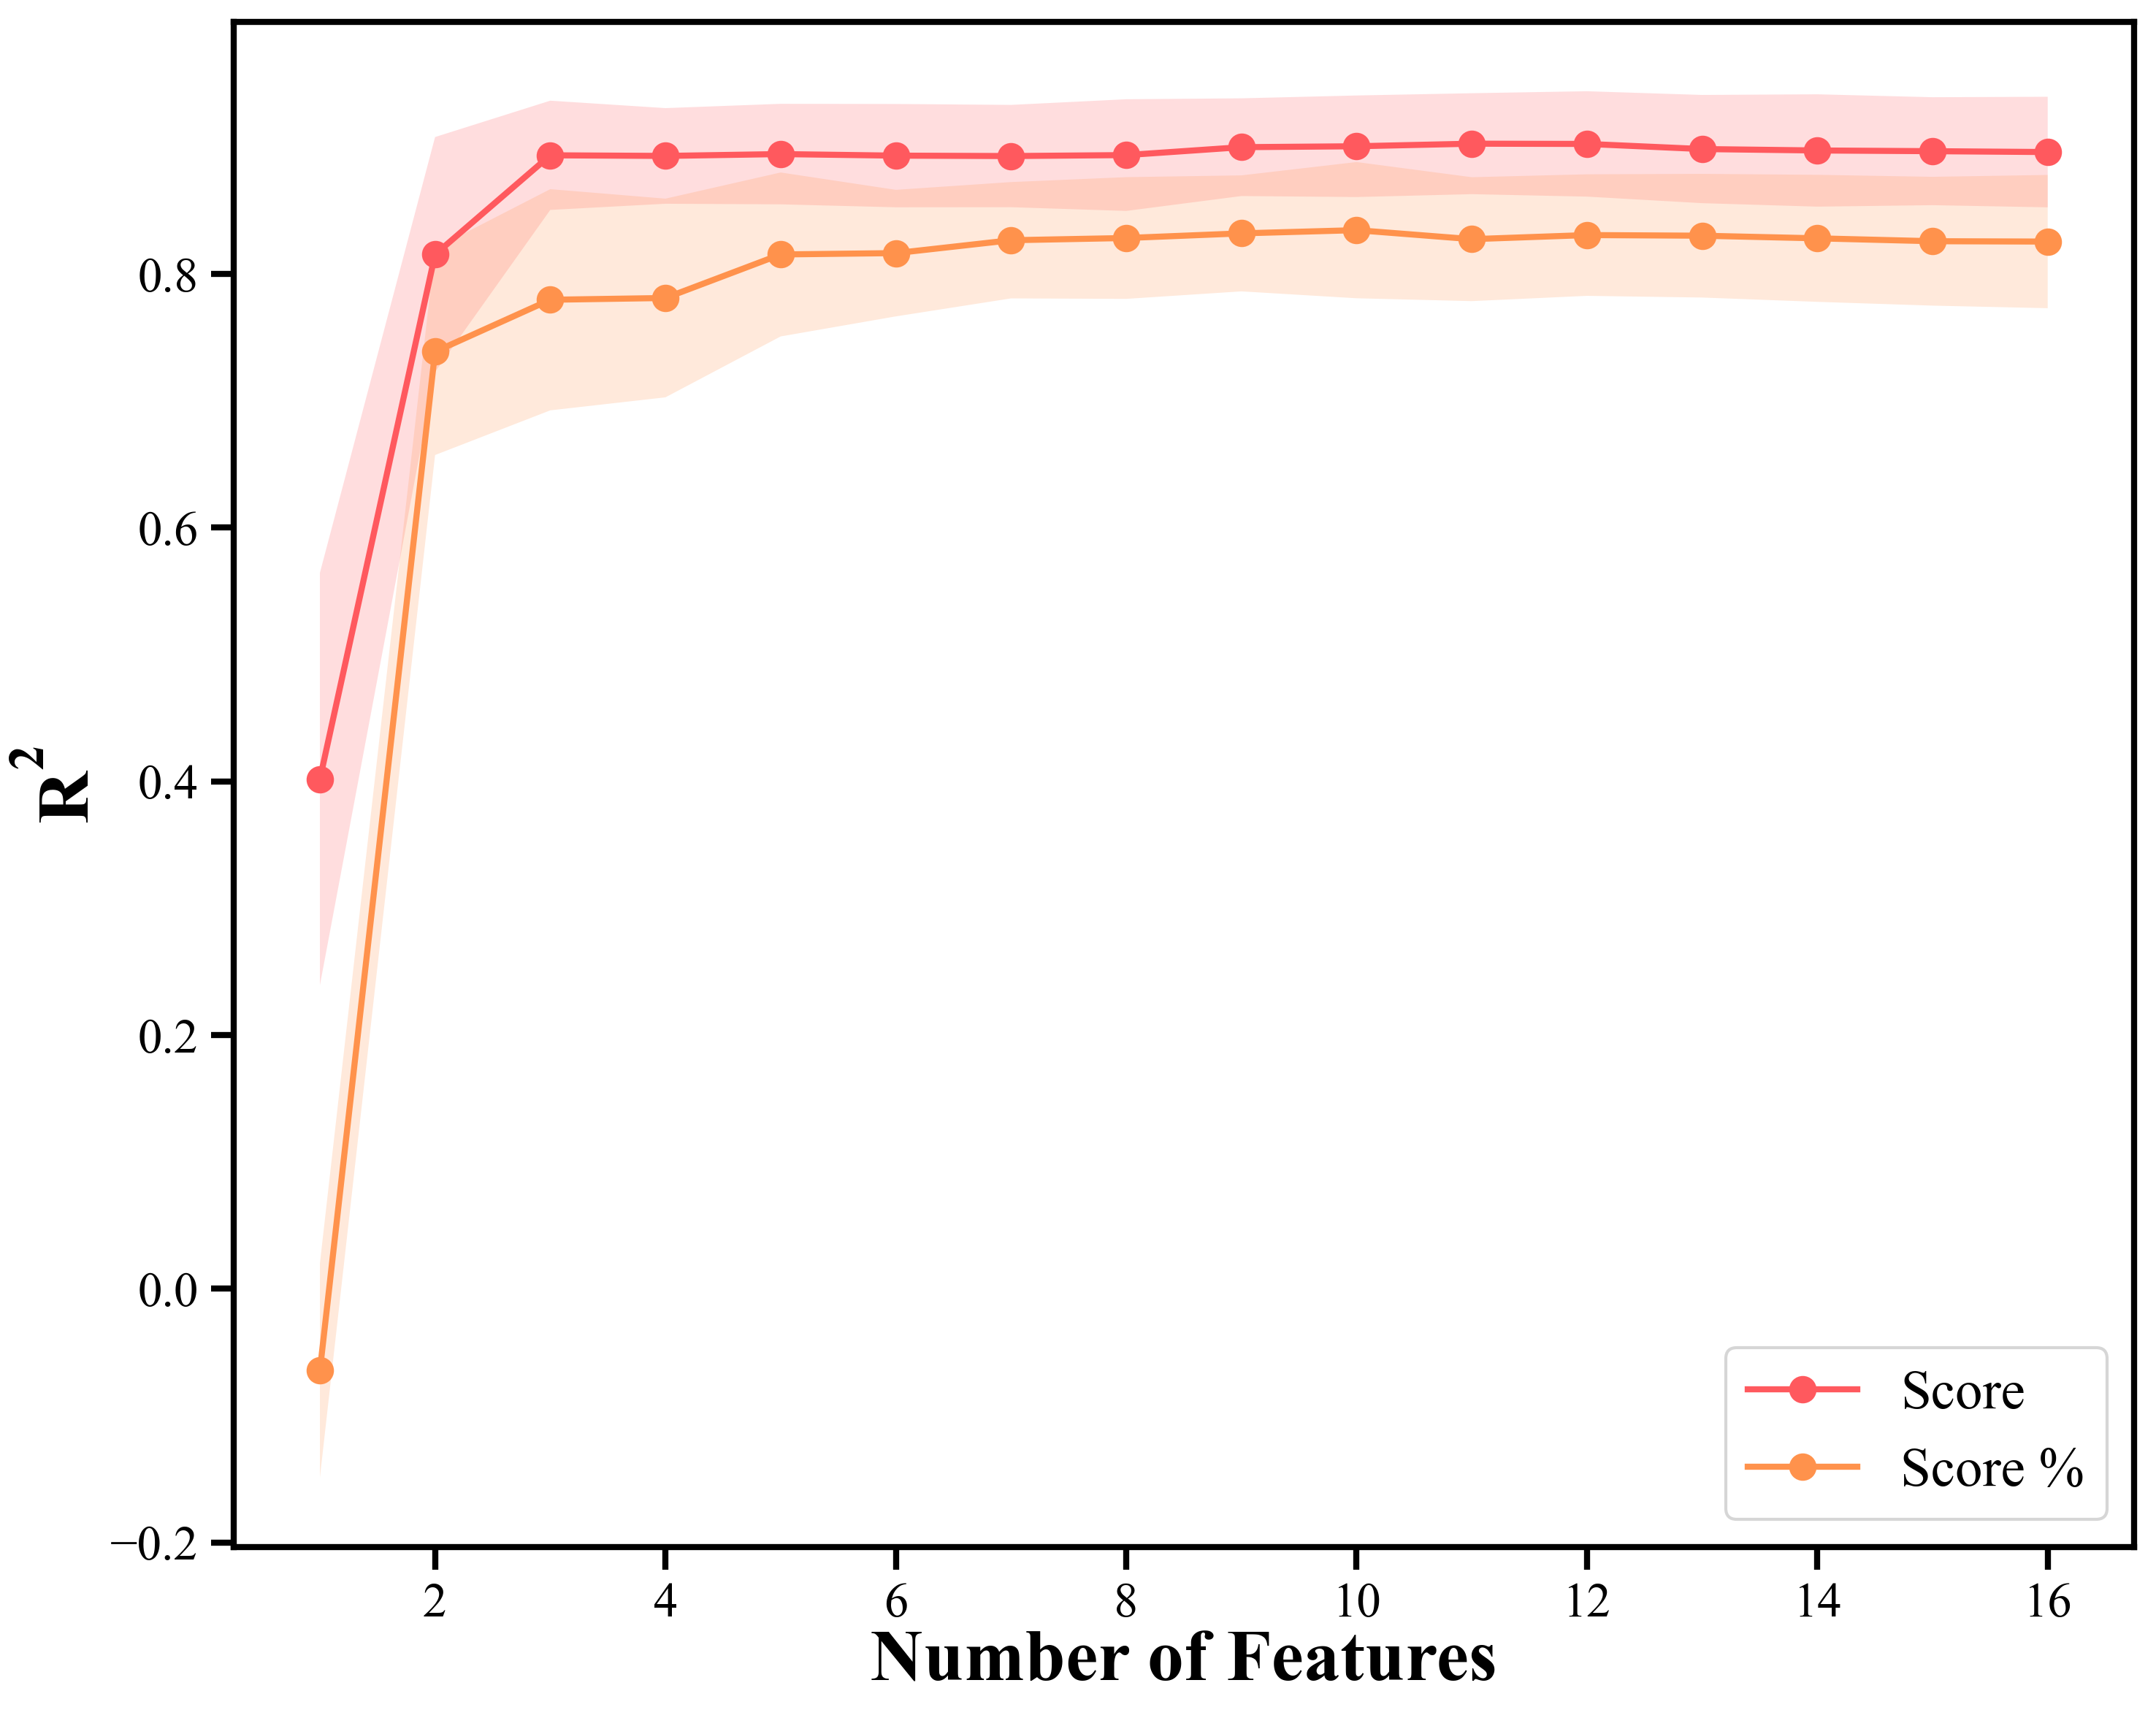

In [9]:
select_cols = ["scores"] + X_cols
exp_df = cur_df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))
print("Used cols", exp_df.columns.tolist())
X = exp_df[X_cols]
y = exp_df["scores"]
model = RandomForestRegressor(n_estimators=500, random_state=42)
selector1, scores1 = plot_rfecv(X, y, model)
selector1_features = X.columns[selector1.support_]
print("Selected features:", selector1_features.tolist())
print("Number of selected features:", len(selector1_features))
np.save("results/feature_selection_scores-1-1.npy", scores1)

select_cols = ["scores_ratio"] + X_cols
exp_df = cur_df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))
print("Used cols", exp_df.columns.tolist())
X = exp_df[X_cols]
y = exp_df["scores_ratio"]
model = RandomForestRegressor(n_estimators=500, random_state=42)
selector2, scores2 = plot_rfecv(X, y, model)
selector2_features = X.columns[selector2.support_]
print("Selected features:", selector2_features.tolist())
print("Number of selected features:", len(selector2_features))
np.save("results/feature_selection_scores-1-2.npy", scores2)

fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('Number of Features')
plt.ylabel(r'$R^2$')
ax.plot(range(1, len(scores1['mean_test_score']) + 1), scores1['mean_test_score'], marker="o", label="Score")
ax.plot(range(1, len(scores2['mean_test_score']) + 1), scores2['mean_test_score'], marker="o", label="Score %")
plt.legend(["Score", "Score %"], loc='lower right', fontsize=18)
std_scores = scores1['std_test_score']
ax.fill_between(range(1, len(scores1['mean_test_score']) + 1),
                scores1['mean_test_score'] - std_scores,
                scores1['mean_test_score'] + std_scores, alpha=0.2)
std_scores = scores2['std_test_score']
ax.fill_between(range(1, len(scores2['mean_test_score']) + 1),
                scores2['mean_test_score'] - std_scores,
                scores2['mean_test_score'] + std_scores, alpha=0.2)
plt.tight_layout()
plt.savefig("plots/feature_selection-1.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
selector1_features = set(selector1_features)
selector2_features = set(selector2_features)
print("Common features:", list(selector1_features & selector2_features))
print("len common features:", len(selector1_features & selector2_features))

Common features: ['corr_max_dcor', 'corr_max_xi', 'dcc_dcor', 'corr_max_mi', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_pearson', 'corr_max_js', 'corr_max_wd']
len common features: 9


In [11]:
all_features = set(selector1_features) | set(selector2_features)
print("All features:", list(all_features))
print("len all features:", len(all_features))

All features: ['dcc_dcor', 'dcc_js', 'corr_max_mi', 'corr_max_pearson', 'corr_max_js', 'corr_max_xi', 'corr_max_dcor', 'corr_max_spearman', 'dcc_pearson', 'corr_max_kendall', 'dcc_xi', 'corr_max_wd']
len all features: 12


Used cols ['scores_boxcox', 'dcc_pearson', 'dcc_spearman', 'dcc_kendall', 'dcc_mi', 'dcc_js', 'dcc_wd', 'dcc_xi', 'dcc_dcor', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_xi', 'corr_max_dcor']
Selected features: ['dcc_js', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_dcor']
Number of selected features: 7
Used cols ['scores_ratio_boxcox', 'dcc_pearson', 'dcc_spearman', 'dcc_kendall', 'dcc_mi', 'dcc_js', 'dcc_wd', 'dcc_xi', 'dcc_dcor', 'corr_max_pearson', 'corr_max_spearman', 'corr_max_kendall', 'corr_max_mi', 'corr_max_js', 'corr_max_wd', 'corr_max_xi', 'corr_max_dcor']
Selected features: ['dcc_pearson', 'dcc_dcor', 'corr_max_pearson', 'corr_max_mi', 'corr_max_js']
Number of selected features: 5


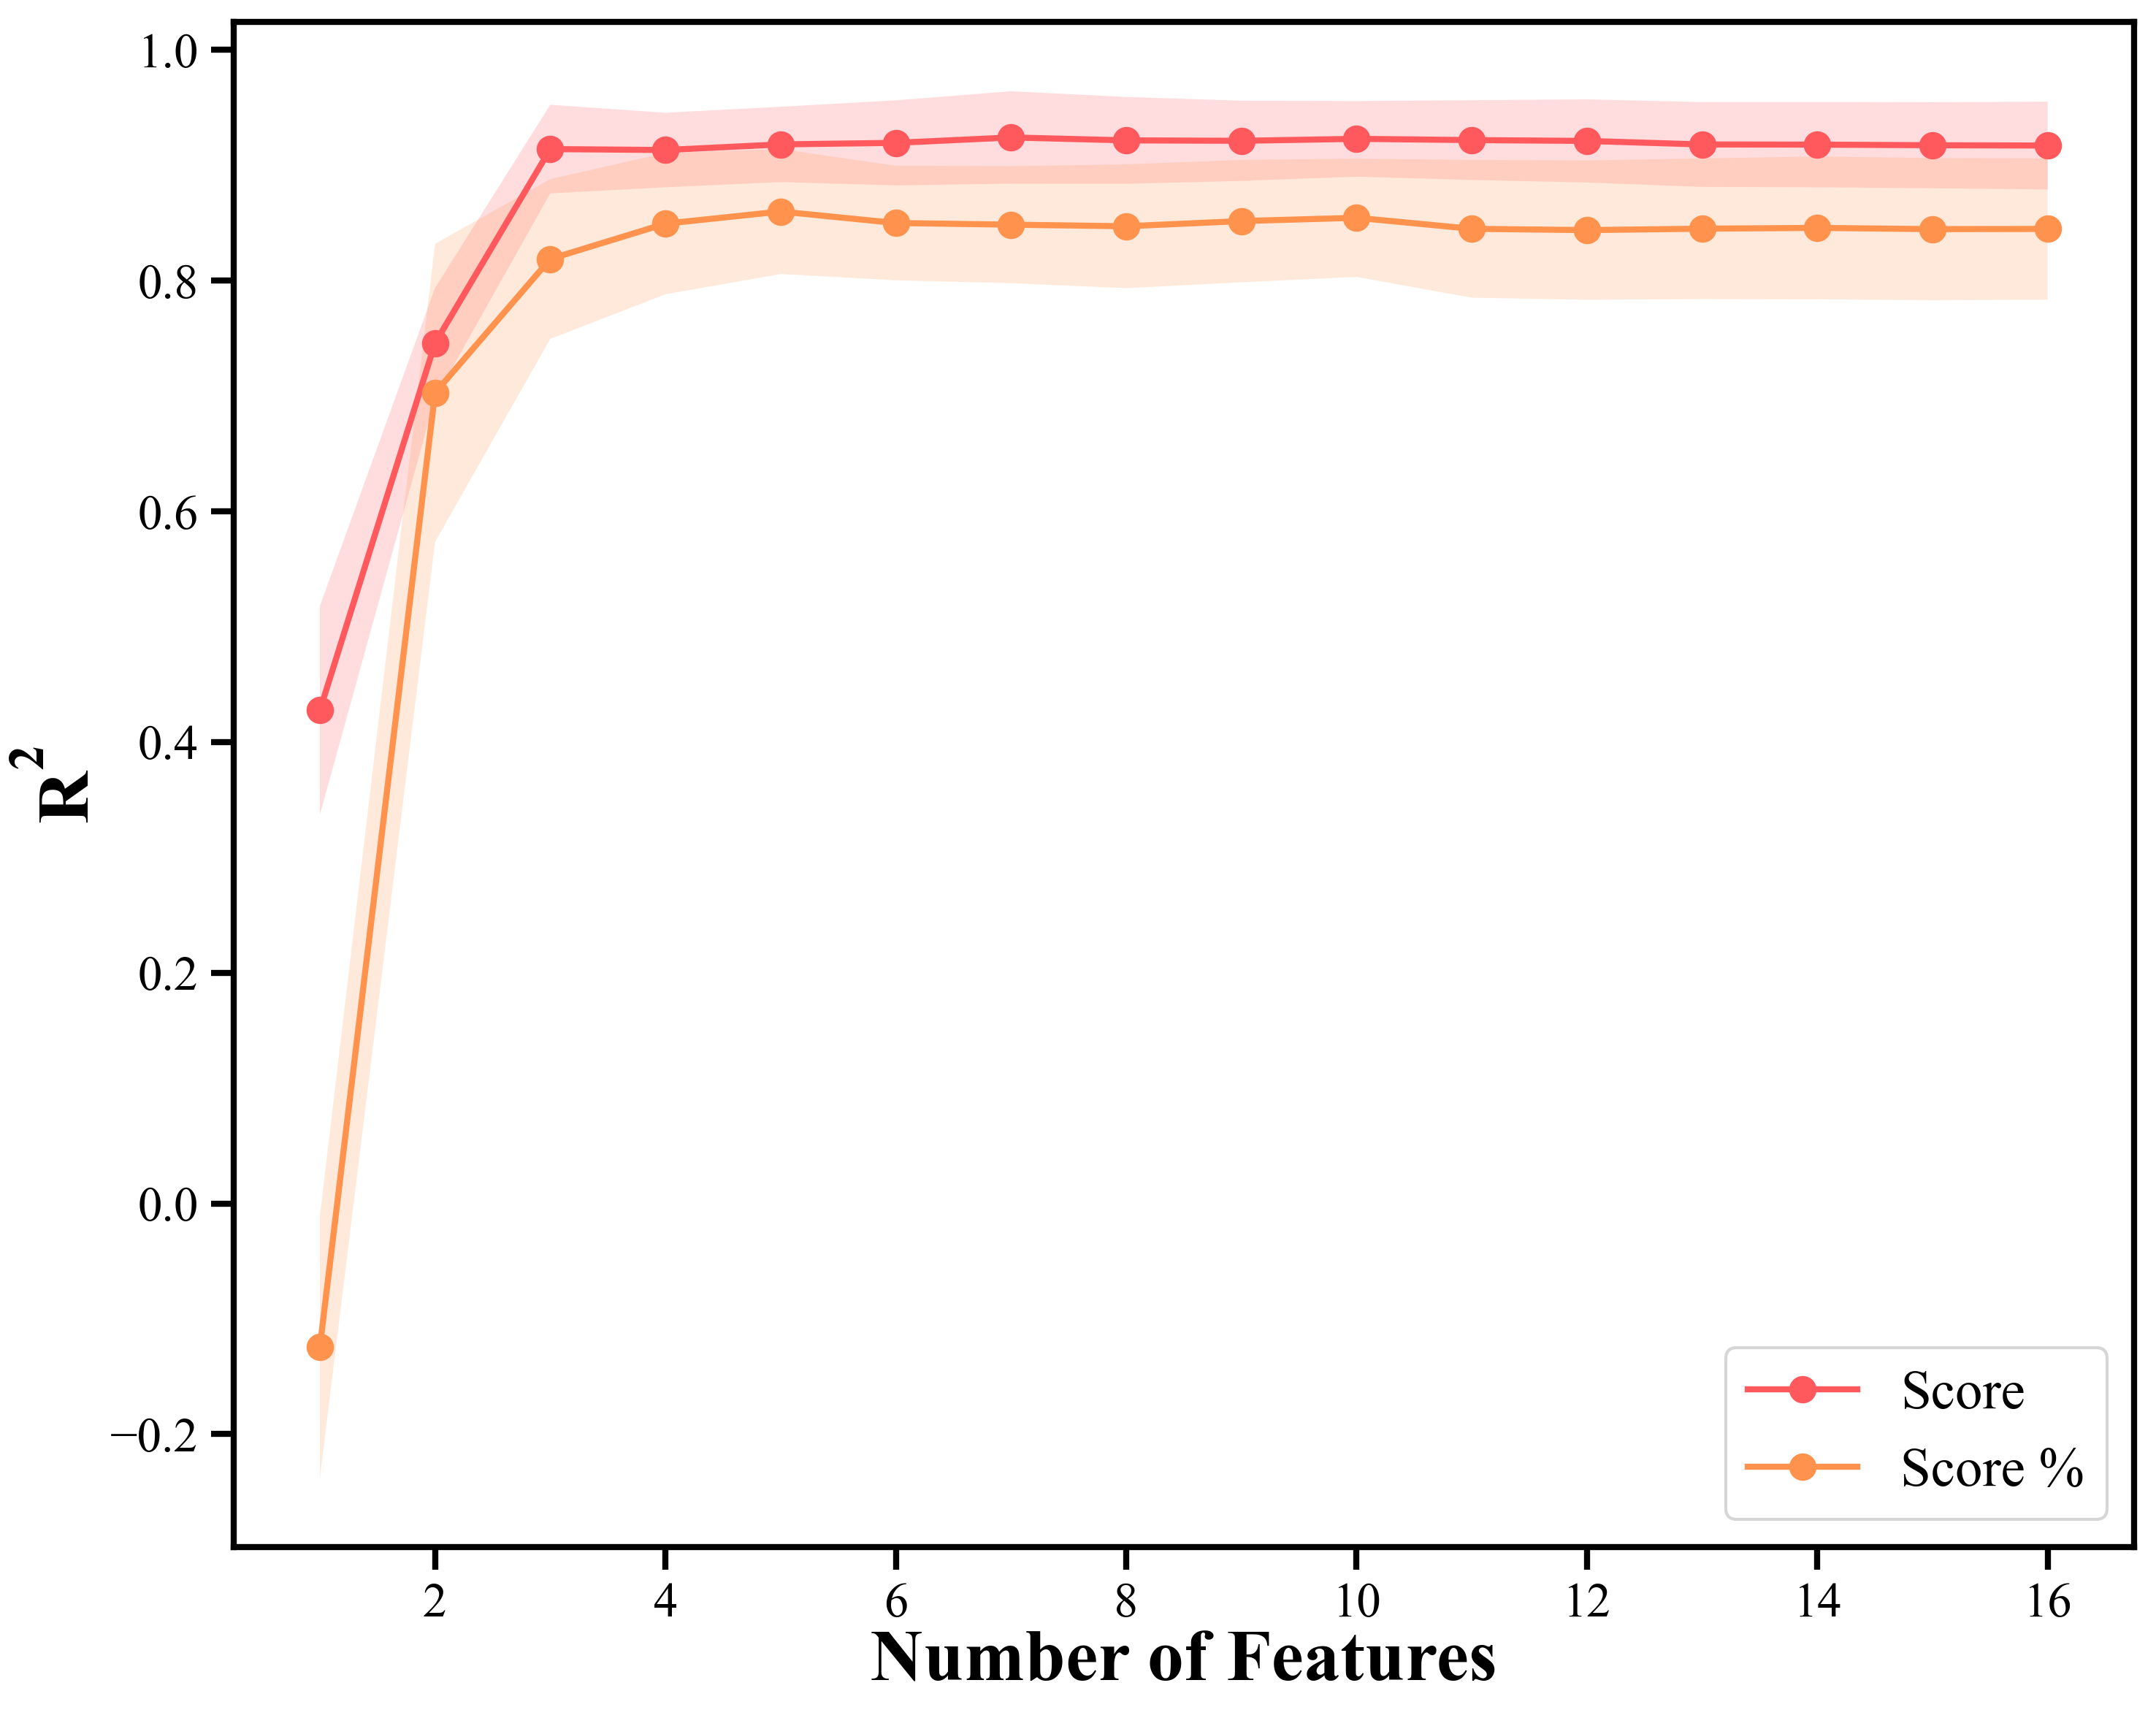

In [15]:
select_cols = ["scores_boxcox"] + X_cols
exp_df = cur_df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))
print("Used cols", exp_df.columns.tolist())
X = exp_df[X_cols]
y = exp_df["scores_boxcox"]
model = RandomForestRegressor(n_estimators=500, random_state=42)
selector1, scores1 = plot_rfecv(X, y, model)
selector1_features = X.columns[selector1.support_]
print("Selected features:", selector1_features.tolist())
print("Number of selected features:", len(selector1_features))
np.save("results/feature_selection_scores-1-3.npy", scores1)

select_cols = ["scores_ratio_boxcox"] + X_cols
exp_df = cur_df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))
print("Used cols", exp_df.columns.tolist())
X = exp_df[X_cols]
y = exp_df["scores_ratio_boxcox"]
model = RandomForestRegressor(n_estimators=500, random_state=42)
selector2, scores2 = plot_rfecv(X, y, model)
selector2_features = X.columns[selector2.support_]
print("Selected features:", selector2_features.tolist())
print("Number of selected features:", len(selector2_features))
np.save("results/feature_selection_scores-1-4.npy", scores2)

fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('Number of Features')
plt.ylabel(r'$R^2$')
ax.plot(range(1, len(scores1['mean_test_score']) + 1), scores1['mean_test_score'], marker="o", label="Score")
ax.plot(range(1, len(scores2['mean_test_score']) + 1), scores2['mean_test_score'], marker="o", label="Score %")
plt.legend(["Score", "Score %"], loc='lower right', fontsize=18)
std_scores = scores1['std_test_score']
ax.fill_between(range(1, len(scores1['mean_test_score']) + 1),
                scores1['mean_test_score'] - std_scores,
                scores1['mean_test_score'] + std_scores, alpha=0.2)
std_scores = scores2['std_test_score']
ax.fill_between(range(1, len(scores2['mean_test_score']) + 1),
                scores2['mean_test_score'] - std_scores,
                scores2['mean_test_score'] + std_scores, alpha=0.2)
plt.tight_layout()
plt.savefig("plots/feature_selection-1-2.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
selector1_features = set(selector1_features)
selector2_features = set(selector2_features)
print("Common features:", list(selector1_features & selector2_features))
print("len common features:", len(selector1_features & selector2_features))

Common features: ['corr_max_mi', 'corr_max_js', 'corr_max_pearson']
len common features: 3


In [17]:
all_features = set(selector1_features) | set(selector2_features)
print("All features:", list(all_features))
print("len all features:", len(all_features))

All features: ['corr_max_dcor', 'dcc_dcor', 'dcc_js', 'corr_max_mi', 'corr_max_spearman', 'dcc_pearson', 'corr_max_pearson', 'corr_max_js', 'corr_max_wd']
len all features: 9
